# Flujo óptico de dos imágenes

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from torchvision.models.optical_flow import raft_large, raft_small
import torchvision.transforms.functional as F
from torchvision.utils import flow_to_image

In [18]:
def read_flo_file(filename):
    with open(filename, 'rb') as f:
        width = np.fromfile(f, np.int32, count=1)[0]
        height = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=2 * width * height)
        flow = np.resize(data, (height, width, 2))
    return flow

In [19]:
image_path_1 = "./sillas/00101_img1.ppm"
image_path_2 = "./sillas/00101_img2.ppm"
image_path_ground_truth = "./sillas/00101_flow.flo"

image1 = cv.imread(image_path_1)
image2 = cv.imread(image_path_2)

flow_data = read_flo_file(image_path_ground_truth)
magnitude = np.sqrt(flow_data[..., 0]**2 + flow_data[..., 1]**2)

old_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
frame_gray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

# Farneback
flow = cv.calcOpticalFlowFarneback(old_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

hsv = np.zeros_like(image1)
hsv[..., 1] = 255  # Saturación constante
hsv[..., 0] = ang * 180 / np.pi / 2  # Dirección del flujo
hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)  # Magnitud del flujo
result_rgb_farneback = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)
image1_rgb = cv.cvtColor(image1, cv.COLOR_BGR2RGB)

# Lucas-Kanade
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

color = np.random.randint(0, 255, (100, 3))
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

mask = np.zeros_like(image1)

if p1 is not None:
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        image2 = cv.circle(image2, (int(a), int(b)), 5, color[i].tolist(), -1)

result = cv.add(image2, mask)
result_rgb_lk = cv.cvtColor(result, cv.COLOR_BGR2RGB)

ValueError: cannot reshape array of size 354762752 into shape (512,1212500304,2)

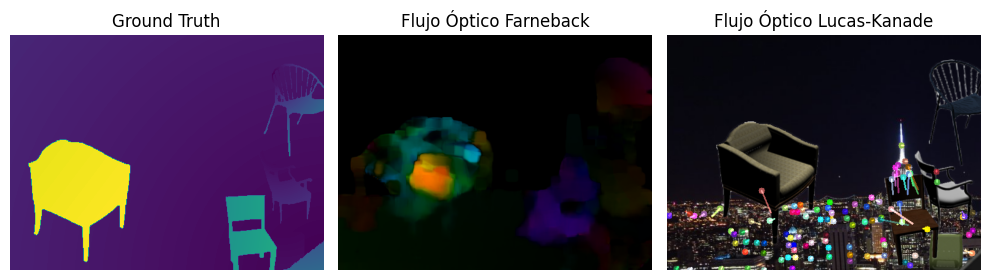

In [ ]:
plt.figure(figsize=(10, 15))

# Imagen original
plt.subplot(1, 3, 1)
plt.imshow(magnitude)
plt.title("Ground Truth")
plt.axis("off")

# Resultado Farneback
plt.subplot(1, 3, 2)
plt.imshow(result_rgb_farneback)
plt.title("Flujo Óptico Farneback")
plt.axis("off")

# Resultado Lucas-Kanade
plt.subplot(1, 3, 3)
plt.imshow(result_rgb_lk)
plt.title("Flujo Óptico Lucas-Kanade")
plt.axis("off")

plt.tight_layout()
plt.savefig("optical_flow_1.svg", format="svg", dpi=300,bbox_inches='tight')
plt.show()

In [20]:
warnings.filterwarnings("ignore")

# RAFT large
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image1_tensor = F.to_tensor(image1).unsqueeze(0).to(device)
image2_tensor = F.to_tensor(image2).unsqueeze(0).to(device)

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

with torch.no_grad():
    list_of_flows = model(image1_tensor, image2_tensor)
    predicted_flow = list_of_flows[-1]

flow_img = flow_to_image(predicted_flow)
flow_img_np = (flow_img.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
flow_img_rgb_raft_large = cv.cvtColor(flow_img_np, cv.COLOR_BGR2RGB)

# RAFT small
model = raft_small(pretrained=True, progress=False).to(device)
model = model.eval()

with torch.no_grad():
    list_of_flows = model(image1_tensor, image2_tensor)
    predicted_flow = list_of_flows[-1]

flow_img = flow_to_image(predicted_flow)
flow_img_np = (flow_img.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
flow_img_rgb_raft_small = cv.cvtColor(flow_img_np, cv.COLOR_BGR2RGB)

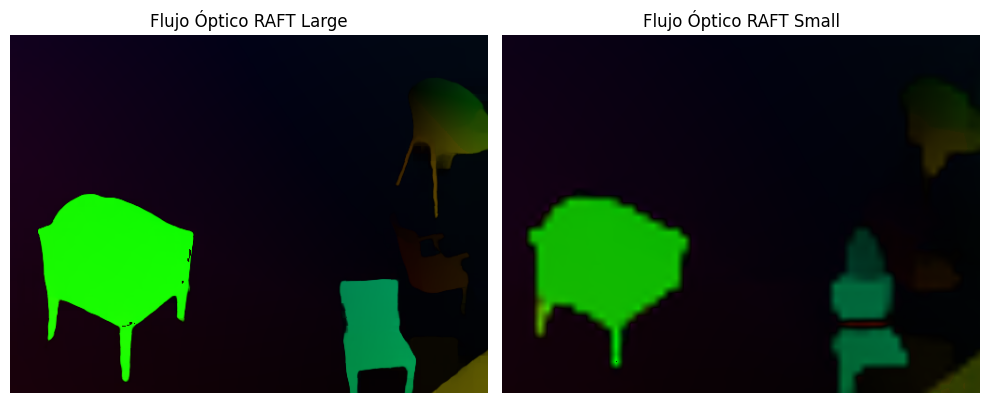

In [21]:
plt.figure(figsize=(10, 15))

# Resultado RAFT large
plt.subplot(1, 2, 1)
plt.imshow(flow_img_rgb_raft_large)
plt.title("Flujo Óptico RAFT Large")
plt.axis("off")

# Resultado RAFT small
plt.subplot(1, 2, 2)
plt.imshow(flow_img_rgb_raft_small)
plt.title("Flujo Óptico RAFT Small")
plt.axis("off")

plt.tight_layout()
plt.savefig("optical_flow_2.svg", format="svg", dpi=300, bbox_inches='tight')
plt.show()